In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, Conv1D, MaxPooling1D, Embedding, Flatten
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
df = pd.read_csv('Combined Data.csv')
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
df.status.unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [6]:
df.status.value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [7]:
df = df[df.status != 'Bipolar']
df = df[df.status != 'Stress']
df = df[df.status != 'Personality disorder']

In [8]:
df.status.value_counts()

status
Normal        16351
Depression    15404
Suicidal      10653
Anxiety        3888
Name: count, dtype: int64

<Axes: xlabel='status', ylabel='count'>

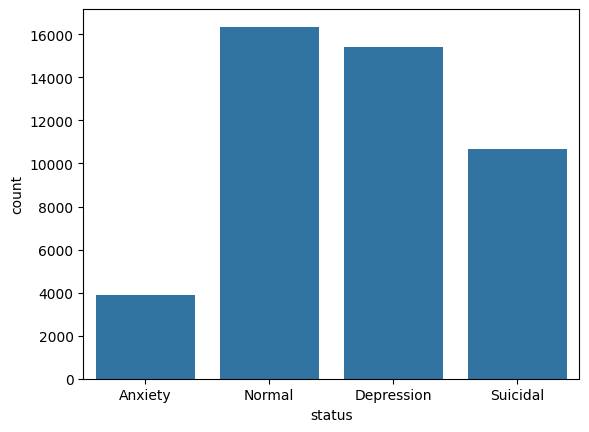

In [9]:
sns.countplot(data = df, x = df.status)

In [10]:
df.isnull().sum()

Unnamed: 0     0
statement     56
status         0
dtype: int64

In [11]:
df.statement = df.statement.fillna(df.statement.mode()[0])

In [12]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [13]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
sw = stopwords.words('english')
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [15]:
df['status'].isnull().sum()

0

In [16]:
import string
import re
lem = WordNetLemmatizer()
def clean(line):
    line = line.lower()
    line = re.sub(r'\d+', '', line)
    line = re.sub(r'[^a-zA-Z0-9\s]', '', line)
    translator = str.maketrans('','',string.punctuation)
    line = line.translate(translator)
    words = [word for word in line.split() if word not in sw]

    return ' '.join(words)


In [17]:
df['statement'] = df['statement'].apply(clean)

In [18]:
for g in df['statement']:
    maxx = g.split()
    m = max([len(maxx)])

m

42

In [19]:
label = LabelEncoder()
df['status'] = label.fit_transform(df['status'])
print(list(label.classes_))

['Anxiety', 'Depression', 'Normal', 'Suicidal']


In [20]:
print(label.transform(['Anxiety', 'Depression', 'Normal', 'Suicidal']))

[0 1 2 3]


In [21]:
x = df['statement']
y = df['status']

In [22]:
tokenizer = Tokenizer(oov_token='<unk>', num_words=2500)
tokenizer.fit_on_texts(x.values)
data_x = tokenizer.texts_to_sequences(x.values)

In [23]:
vocab = tokenizer.word_index
l_voc = len(vocab)
l_voc

69237

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
em = 50
pad_sz = 42
latent = 200
data_x = pad_sequences(data_x, maxlen=pad_sz, padding = 'post', truncating = 'post')

In [25]:
kernel_size = 5
filters = 64
pool_size = 4

In [26]:
model = Sequential()
model.add(Embedding(l_voc, em, input_length = pad_sz))
model.add(Dropout(0.25))

model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))

model.add(MaxPooling1D(pool_size = pool_size))
model.add(LSTM(latent))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build((None, pad_sz))
model.summary()


c:\Python Environment\environments\computational_biology\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 42, 50)         │     3,461,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 38, 64)         │        16,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200)            │       212,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,690,718 (14.08 MB)

 Trainable params: 3,690,718 (14.08 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
y = pd.get_dummies(y).values
x_train, x_test, y_train, y_test = train_test_split(data_x, y,shuffle=True, stratify=y, test_size=0.2)

In [31]:
history = model.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.6116 - loss: 0.9061 - val_accuracy: 0.7243 - val_loss: 0.6180
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.7730 - loss: 0.5356 - val_accuracy: 0.7641 - val_loss: 0.5545
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.7937 - loss: 0.4845 - val_accuracy: 0.7687 - val_loss: 0.5473
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8167 - loss: 0.4332 - val_accuracy: 0.7759 - val_loss: 0.5397
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8350 - loss: 0.3962 - val_accuracy: 0.7778 - val_loss: 0.5416
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8450 - loss: 0.3740 - val_accuracy: 0.7670 - val_loss: 0.5897
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8606 - loss: 0.3392 - val_accuracy: 0.7719 - val_loss: 0.5660
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8775 - loss: 0.3078 - 

In [32]:
score, acc = model.evaluate(x_test, y_test)
print(score)
print(acc)

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7601 - loss: 1.1234
1.1814308166503906
0.7516198754310608


In [33]:
predict = model.predict(x_test)
predict

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


array([[7.8009080e-06, 9.9948514e-01, 7.7817026e-07, 5.0622778e-04],
       [6.0654993e-06, 4.6304832e-03, 1.5150168e-05, 9.9534827e-01],
       [1.1790038e-06, 9.9999428e-01, 2.7562669e-07, 4.2790552e-06],
       ...,
       [1.4771408e-04, 9.2871755e-01, 3.8124745e-05, 7.1096554e-02],
       [2.6458358e-06, 3.2447674e-06, 9.9999237e-01, 1.8179726e-06],
       [7.3264027e-04, 9.8816353e-01, 1.4843571e-04, 1.0955318e-02]],
      dtype=float32)